<div style="font-family: 'Courier New', Courier, monospace; font-size: 1.8em; color: #f6f8fa; background-color: #24292e; border: 2px solid #444d56; border-radius: 6px; padding: 10px 20px; margin-top: 20px; box-shadow: 0 2px 5px rgba(0, 0, 0, 0.1);">
    <span style="font-weight: 600; font-size: 1.1em; letter-spacing: 0.5px; color: #f0f6fc;">1. Notebook Overview</span>
</div>


<div style="font-family: 'Arial', sans-serif; line-height: 1.7; color: #333; max-width: 1000px; margin: auto; padding: 15px;">

  <p style="font-size: 1.2em; margin-bottom: 20px;">
    Welcome to the 2nd notebook in our three-part series! In this section, we’ll use the vNetRunner framework to train the <strong>RAN</strong>, <strong>OvS</strong>, and <strong>UPF</strong> VNF models as shown below:
  </p>

  <div align="center" style="margin: 25px 0; padding: 15px; background-color: white; border: 1px solid #444; border-radius: 8px;">
    <img src="images/VNF_model.png" alt="vNetRunner Overview" width="300"" />
  </div>

  <p style="font-size: 1.2em; margin-bottom: 20px;">
    After training the VNFs, we will compose an <strong>end-to-end 5G network slice model</strong> using the trained VNF models, as illustrated below:
  </p>

  <div align="center" style="margin: 25px 0; padding: 15px; background-color: white; border: 1px solid #444; border-radius: 8px;">
    <img src="images/vNetRunner.png" alt="vNetRunner Overview" width="600"" />
  </div>

  <p style="font-size: 1.2em; margin-bottom: 20px;">
    Let's get started!
  </p>

  </p>
</div>


<div style="font-family: 'Courier New', Courier, monospace; font-size: 1.8em; color: #f6f8fa; background-color: #24292e; border: 2px solid #444d56; border-radius: 6px; padding: 10px 20px; margin-top: 20px; box-shadow: 0 2px 5px rgba(0, 0, 0, 0.1);">
    <span style="font-weight: 600; font-size: 1.1em; letter-spacing: 0.5px; color: #f0f6fc;">2. Importing the necessary libraries</span>
</div>


In [6]:
%%capture
%load_ext autoreload
%autoreload 2

from data_generator import DataGenerator as DataGenerator
from matplotlib import pyplot as plt
import pandas as pd
import ipywidgets as widgets
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from IPython.display import display
import math

from vnf_model import *
from slice_model import *
from resource_allocation import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

<div style="font-family: 'Courier New', Courier, monospace; font-size: 1.8em; color: #f6f8fa; background-color: #24292e; border: 2px solid #444d56; border-radius: 6px; padding: 10px 20px; margin-top: 20px; box-shadow: 0 2px 5px rgba(0, 0, 0, 0.1);">
    <span style="font-weight: 600; font-size: 1.1em; letter-spacing: 0.5px; color: #f0f6fc;">3. A High-level Introduction to Deep Learning</span>
</div>


<div style="font-family: 'Arial', sans-serif; line-height: 1.7; color: #333; max-width: 1000px; margin: auto; padding: 15px;">

  <p style="font-size: 1.2em; margin-bottom: 20px;">
    Before we begin modeling the VNFs, let's quickly review how neural networks work. In this section, we are going to learn the basics of deep learning using <strong>PyTorch</strong> at a very high level. 
    After completing this section, you are expected to know the essential components of training a basic neural network with PyTorch.
    To illustrate the concepts, we will cover an example regression task using a simple feedforward neural network.
</div>


<div style="display: inline-block;">
    <h2 style="font-family: 'Courier New', Courier, monospace; font-size: 1.5em; color: #f0f6fc; background-color: #2d333b; border-left: 4px solid #3F51B5; padding: 8px 15px; border-radius: 4px; margin-top: 20px; box-shadow: 0 1px 3px rgba(0, 0, 0, 0.1);">
        3a. Generating synthetic dataset
    </h2>
</div>


In [ ]:
# Generating synthetic data
X = np.linspace(0, 20, 10000)  # Generate 100 evenly spaced values between 0 and 10

# Y = 3 + sine(x) + noise
Y = 3 + np.sin(X) + np.random.randn(10000) * 0.1

# Remove data where x in even multiple of 5 to 5+2.5
filter_indices = np.zeros_like(X, dtype=bool)  # Initialize a boolean array of the same length as X
for i in range(4):
    filter_indices |= (X >= 5*i) & (X <= 5*i+1.25)  # Update the boolean array with the condition

X = X[~filter_indices]
Y = Y[~filter_indices]

# Convert to PyTorch tensors
X_train = torch.tensor(X, dtype=torch.float32).view(-1, 1)
Y_train = torch.tensor(Y, dtype=torch.float32).view(-1, 1)

# Plotting the data
plt.scatter(X_train[::75], Y_train[::75], label='Data')
plt.title('Generated Data for Linear Regression')
plt.xlabel('X (Input)')
plt.ylabel('Y (Output)')
plt.legend()
plt.grid()
plt.show()

<div style="display: inline-block;">
    <h2 style="font-family: 'Courier New', Courier, monospace; font-size: 1.5em; color: #f0f6fc; background-color: #2d333b; border-left: 4px solid #3F51B5; padding: 8px 15px; border-radius: 4px; margin-top: 20px; box-shadow: 0 1px 3px rgba(0, 0, 0, 0.1);">
        3b. Creating a simple feedforward neural network
    </h2>
</div>


 <div style="font-family: 'Arial', sans-serif; line-height: 1.7; color: #333; max-width: 1000px; margin: auto; padding: 15px;">

 <div align="center" style="margin: 25px 0; padding: 15px; background-color: white; border: 1px solid #444; border-radius: 8px;">
    <img src="images/FFNet.png" alt="Feedforward Neural Network" width="400"" />
  </div>
  
<div style="font-family: Arial, sans-serif; color: #333; line-height: 1.6; max-width: 600px;">
  <h3 style="color: #4CAF50; padding-bottom: 5px; border-bottom: 2px solid #4CAF50; margin-bottom: 15px;">Model Components</h3>

  <h4 style="color: #4CAF50; margin-top: 15px;">Model Architecture</h4>
  
  <p style="font-size: 1.1em; margin-top: 10px;">
    <strong>Input Layer</strong> (<code>self.linear_1</code>): The input layer is a fully connected layer that receives the input features, applies a linear transformation, and passes the output to the next layer. This layer converts the initial data into a higher-dimensional space, preparing it for subsequent layers.
  </p>

  <p style="font-size: 1.1em; margin-top: 10px;">
    <strong>Hidden Layers</strong> (<code>self.linear_hidden</code>): This module list contains multiple fully connected hidden layers, each followed by a ReLU activation. The hidden layers allow the model to capture non-linear relationships and complex patterns in the data. Increasing the number of hidden layers and neurons can improve the model’s capacity but may also increase the risk of overfitting.
  </p>

  <p style="font-size: 1.1em; margin-top: 10px;">
    <strong>Output Layer</strong> (<code>self.linear_out</code>): The output layer is a fully connected layer that produces the final prediction of the model. In this case, it outputs a single continuous value, which is suitable for regression tasks.
  </p>
  
  <h4 style="color: #4CAF50; margin-top: 15px;">Training Loop</h4>
  
  <p style="font-size: 1.1em; margin-top: 10px;">
    <strong>Training Loop</strong> (<code>train(args)</code>): This function manages the training process by running multiple epochs. Each epoch samples a batch of data, computes predictions, calculates the loss, and adjusts the model's weights (using the optimizer) to minimize the loss over time.
  </p>

  <p style="font-size: 1.1em; margin-top: 10px;">
    <strong>Mean Squared Error Loss Function</strong> (<code>mse_loss(y_pred, y_true)</code>): This loss function calculates the mean squared difference between the model’s predictions and the true values, penalizing larger errors more heavily. Minimizing this loss helps the model make more accurate predictions.
  </p>

    
  <p style="font-size: 1.1em; margin-top: 10px;">
    <strong>Stochastic Gradient Descent Optimizer</strong> (<code>torch.optim.SGD(model.parameters(), lr=learning_rate)</code>): The optimizer is responsible for adjusting the model’s weights based on the computed gradients from the loss function. Stochastic Gradient Descent (SGD) updates the weights iteratively using these gradients. The learning rate determines the step size for each update, balancing the speed of convergence with stability.
  </p>
</div>

</div>

In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Defining a class for the linear regression model, inheriting from nn.Module
class LinearRegressionModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        
        # Model Architecture #####################################################################################
        # Batch Normalization Layer
        self.bn_1 = nn.BatchNorm1d(n_input)  # Normalizes input features
        
        # Input Layer
        self.linear_1 = nn.Linear(n_input, n_hidden[0])  # Transforms input to the first hidden layer
        
        # Hidden Layers
        self.linear_hidden = nn.ModuleList(
            [nn.Linear(n_hidden[i], n_hidden[i+1]) for i in range(len(n_hidden) - 1)]
        )  # List of hidden layers with ReLU activations
        
        # Output Layer
        self.linear_out = nn.Linear(n_hidden[-1], n_output)  # Produces final prediction for regression

    # Define the forward pass for the model
    def forward(self, x):
        x = self.bn_1(x)  # Normalize input features
        x = self.linear_1(x)  # Pass through input layer
        x = nn.ReLU()(x)  # Apply ReLU activation

        # Pass through each hidden layer with ReLU activation
        for hidden_layer in self.linear_hidden:
            x = hidden_layer(x)
            x = nn.ReLU()(x)

        # Output layer for final prediction
        x = self.linear_out(x)
        return x
    
    # Loss Function ###############################################################################################
    # Mean Squared Error Loss Function
    def mse_loss(self, y_pred, y_true):
        return torch.mean((y_pred - y_true) ** 2)

    def __str__(self):
        # Custom printout to show model architecture
        model_str = "LinearRegressionModel Architecture:\n"
        model_str += f"{'Input Layer':<20} -> {self.linear_1}\n"
        for i, layer in enumerate(self.linear_hidden, 1):
            model_str += f"Hidden Layer {i:<10} -> {layer}\n"
        model_str += f"{'Output Layer':<20} -> {self.linear_out}\n"
        return model_str
    
    # Training Loop ###############################################################################################
    def train(self, X, Y, num_epochs=1000, batch_size=32, learning_rate=0.01):
        loss_history = []
        optimizer = optim.SGD(self.parameters(), lr=learning_rate)  # Stochastic Gradient Descent optimizer

        # Training over specified epochs
        for epoch in range(num_epochs):
            # Sample a batch of data points
            sampled_indices = np.random.choice(len(X), batch_size)
            X_batch = X[sampled_indices]
            Y_batch = Y[sampled_indices]

            # Zero gradients from previous iteration
            optimizer.zero_grad()
            
            # Forward pass: predict and compute loss
            y_pred = self(X_batch)
            loss = self.mse_loss(y_pred, Y_batch)
            
            # Backward pass: compute gradients and update weights
            loss.backward()
            optimizer.step()

            # Record the loss
            loss_history.append(loss.item())
            
            # Print loss periodically
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, MSE Loss: {loss.item()}", end='\r')
                if epoch % 1000 == 0:
                    print()

        return loss_history


In [ ]:
# Initialize an instance of the LinearRegressionModel
model = LinearRegressionModel(1, [16, 8, 4], 1)
# Print the model architecture
print(model)

<div style="display: inline-block;">
    <h2 style="font-family: 'Courier New', Courier, monospace; font-size: 1.5em; color: #f0f6fc; background-color: #2d333b; border-left: 4px solid #3F51B5; padding: 8px 15px; border-radius: 4px; margin-top: 20px; box-shadow: 0 1px 3px rgba(0, 0, 0, 0.1);">
        3c. Instantiationg and training the model
    </h2>
</div>


In [ ]:

# Initialize an instance of the LinearRegressionModel
model = LinearRegressionModel(n_input=1, 
                              n_hidden=[32, 16, 8], #[16, 8] <--- Play around with the number of hidden layers and neurons
                              n_output=1) 
# Print the model architecture
print(model, end='\n\n')

loss_history = model.train(X_train, Y_train, 
                           num_epochs=5000,      # 5000 <--- Play around with the number of epochs
                           batch_size=512,       # 128 <--- Play around with the batch size
                           learning_rate=0.01)   #0.01 <--- Play around with the learning rate

print(f"Final loss: {np.mean(loss_history[-500:])}")
# Plotting the loss history
plt.plot(loss_history, label='MSE Loss')
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid()
plt.show()

# Plotting the model predictions
plt.scatter(X_train[::75], Y_train[::75], label='Data')
plt.plot(X_train, model(X_train).detach().cpu().numpy(), label='Model Predictions', color='red')
plt.title('Model Predictions')
plt.xlabel('X (Input)')
plt.ylabel('Y (Output)')
plt.legend()
plt.grid()
plt.show()

<!-- <div style="font-family: Arial, sans-serif; color: #333; line-height: 1.6; max-width: 600px;"> -->
<div style="font-family: 'Arial', sans-serif; line-height: 1.7; color: #333; max-width: 1000px; margin: auto; padding: 15px;"> 
  <h3 style="color: #4CAF50; padding-bottom: 5px; border-bottom: 2px solid #4CAF50; margin-bottom: 15px;">Optimizing Hyperparameters for Model Training</h3>

  <p style="font-size: 1.1em; margin-top: 10px;">
    <strong>Hidden Layers & Neurons</strong> (<code>n_hidden</code>): This parameter sets the <em>number of layers</em> and <em>neurons per layer</em>, affecting the model's ability to capture complex patterns. More neurons allow for richer representations but increase the risk of overfitting and computational load. Finding a balanced architecture helps achieve accuracy without excess complexity.
  </p>

  <p style="font-size: 1.1em; margin-top: 10px;">
    <strong>Learning Rate</strong> (<code>learning_rate</code>): The <em>learning rate</em> determines the size of each training step. A higher rate accelerates learning but risks overshooting optimal values, leading to instability. A lower rate ensures steady, precise updates but may converge slowly. Adjusting this rate is key to balancing speed with accuracy.
  </p>

  <p style="font-size: 1.1em; margin-top: 10px;">
    <strong>Batch Size</strong> (<code>batch_size</code>): The <em>batch size</em> is the number of samples processed before updating model weights. Larger batches can improve computation speed and reduce update noise, but may lead to overfitting and lose generalizability. Smaller batches introduce beneficial randomness, supporting better generalization, though they can slow down convergence and add variance.
  </p>

  <p style="font-size: 1.1em; margin-top: 10px;">
    <strong>Epochs</strong> (<code>num_epochs</code>): The <em>number of epochs</em> sets how many times the model sees the entire dataset during training. Fewer epochs may cause underfitting, while too many can lead to overfitting and excess training time. Choosing the right number of epochs helps balance model performance with efficient training.
  </p>

</div>


<div style="font-family: Arial, sans-serif; color: #222; line-height: 1.6; max-width: 700px; margin: 20px auto; padding: 20px; border: 1px solid #444; border-radius: 8px; background-color: #eaeaea; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.15);">
  <h2 style="color: #ffffff; background-color: #333333; padding: 10px; border-radius: 4px; margin-bottom: 20px; text-align: center;">Exercise: Hyperparameter Tuning</h2>
  
  <p style="font-size: 1.1em; margin-top: 15px; margin-bottom: 20px;">
  </p>
    In this exercise, you will experiment with different hyperparameters to help your model better fit the data i.e., reduce the final loss. You’ll work with the following hyperparameters: <code>learning_rate</code>, <code>batch_size</code>, <code>n_hidden</code>, and <code>num_epochs</code>. By adjusting these, you’ll explore their impact on the model’s ability to capture patterns and reduce error.
  
  <h3 style="color: #ff9800; margin-bottom: 15px;">Hyperparameter to try</h3>
  <ol style="font-size: 1.1em; margin-left: 25px; margin-bottom: 20px;">
    <li>Try increasing the <code>n_hidden</code> parameter (e.g., <code>[32, 16]</code> or <code>[32, 16, 8]</code>).</li>
    <li>Experiment with a smaller <code>learning_rate</code> (e.g., <code>0.01</code> or <code>0.001</code>).</li>
    <li>Adjust the <code>batch_size</code> to a higher value (e.g., <code>256</code> or <code>512</code>).</li>
    <li>Increase the <code>num_epochs</code> (e.g., <code>5000</code>).</li>
  </ol>
  
  <h4 style="color: #333333; margin-top: 25px; margin-bottom: 10px; border-bottom: 1px solid #999; padding-bottom: 5px;">Hint:</h4>
  <p style="font-size: 1.05em; margin-bottom: 20px;">
    To evaluate changes, look at the <code>final loss</code> values at different hyperparameter combinations. Try to find the best combination of hyperparameters that gives the lowest final loss.
  </p>
  
  <h4 style="color: #333333; margin-bottom: 10px; border-bottom: 1px solid #999; padding-bottom: 5px;">Examples:</h4>
  <ul style="font-size: 1.05em; margin-left: 25px;">
    <li><code>model = LinearRegressionModel(1, [64, 128], 1)</code> – Create a model with 2 hidden layers, 64 neurons in the first layer and 128 neurons in the second layer.</li>
    <li><code>loss_history = model.train(X_train, Y_train, num_epochs=2000, batch_size=64, learning_rate=0.0005)</code> – Train the model with 2000 epochs, a batch size of 64, and a learning rate of 0.0005.</li>
  </ul>
</div>


<center>Double click here to see the solution</center>

<!-- 
n_hidden = [32, 16, 8]
batch_size = 512
learning_rate = 0.01
num_epochs = 5000
-->


<div style="font-family: 'Courier New', Courier, monospace; font-size: 1.8em; color: #f6f8fa; background-color: #24292e; border: 2px solid #444d56; border-radius: 6px; padding: 10px 20px; margin-top: 20px; box-shadow: 0 2px 5px rgba(0, 0, 0, 0.1);">
    <span style="font-weight: 600; font-size: 1.1em; letter-spacing: 0.5px; color: #f0f6fc;">4. VNF Modeling</span>
</div>


<div style="font-family: 'Arial', sans-serif; line-height: 1.7; color: #333; max-width: 1000px; margin: auto; padding: 15px;">

 <div align="center" style="margin: 25px 0; padding: 15px; background-color: white; border: 1px solid #444; border-radius: 8px;">
    <img src="images/VNF_model.png" alt="VNF Model" width="400"" />
  </div>

 <div align="center" style="margin: 25px 0; padding: 15px; background-color: white; border: 1px solid #444; border-radius: 8px;">
    <img src="images/VNFNet.png" alt="VNG Model" width="400"" />
  </div>


<div style="font-family: 'Arial', sans-serif; line-height: 1.7; color: #333; max-width: 800px; margin: auto; padding: 15px;">

  <p style="font-size: 1.2em; margin-bottom: 20px;">
    In this part of the notebook, we will train the ML models for the VNFs.  Before we begin, let's take a look at the `VNF_Model` class in <a href="https://github.com/sulaimanalmani/5GDynamicResourceAllocation/blob/main/vnf_model.py" target="_blank" style="color: #2196F3; text-decoration: none;">vnf_model.py</a> and identify the components we discussed in the previous section (model architecture, loss function, and training loop).
  </p>
</div>
</div>

<div style="display: inline-block;">
    <h2 style="font-family: 'Courier New', Courier, monospace; font-size: 1.5em; color: #f0f6fc; background-color: #2d333b; border-left: 4px solid #3F51B5; padding: 8px 15px; border-radius: 4px; margin-top: 20px; box-shadow: 0 1px 3px rgba(0, 0, 0, 0.1);">
        4a. Training and plotting the RAN VNF model
    </h2>
</div>


Test Loss: -3.54108977317810060414571762085, Val Loss: -3.50391936302185067455


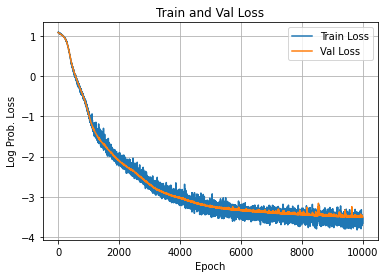

In [46]:
ran_data_gen = DataGenerator('./net_model_dataset/ran/input_dataset.pkl', './net_model_dataset/ran/output_dataset.pkl', vnf_type='RAN', norm_type='minmax')
ran_model = VNF_Model(vnf_typ='ran', 
                      n_inputs=6,
                      n_hidden=[64, 32, 16],
                      n_outputs=5)
ran_model.to(device)
train_loss, val_loss = ran_model.train(ran_data_gen, num_epochs=10000, batch_size=256)

# Plot train and val_loss
ran_model.plot_loss()

RAN


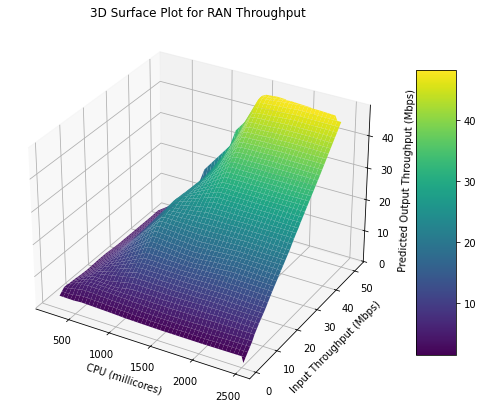

In [47]:
# Plotting the RAN model predictions
input_df, _ = ran_data_gen.sample('train')
input_df = torch.tensor(input_df.values, dtype=torch.float).to(device)
pred_df = ran_model.predict(input_df)
pred_df = pred_df.detach().cpu().numpy()

# Make a 3d plot 
ran_data_gen.create_3d_plot(output_throughput=pred_df[:, 2])

In [60]:
import numpy as np
import torch
import ipywidgets as widgets
from plotly import graph_objs as go
from IPython.display import display

# ran_data_gen = DataGenerator('./net_model_dataset/ran/input_dataset.pkl', './net_model_dataset/ran/output_dataset.pkl', vnf_type='RAN', norm_type='minmax')
# ran_model = VNF_Model('ran', 6, [64, 32, 16], 5)
# ran_model.to(device)
# ran_model.load_weights('./data/saved_weights/ran/model.pth')

# Slider creation with common layout and styling
def create_slider(value, min_val, max_val, step, description):
    return widgets.FloatSlider(
        value=value,
        min=min_val,
        max=max_val,
        step=step,
        description=description,
        continuous_update=True,
        style={'description_width': '200px'},
        layout=widgets.Layout(width='50%', padding='10px 0px')
    )

# Sliders for input throughput and resource allocation
input_throughput_slider = create_slider(5, 5, 50, 0.05, 'Input Throughput (Mbps):')
resource_allocation_slider = create_slider(250, 250, 2500, 1, 'Resource Allocation (millicores):')

# Metric labels and units
metric_labels = ["Input Throughput", "Resource Allocation", "Output Throughput", "Packet Loss"]
output_values = {label: widgets.Label("No data") for label in ["Output Throughput", "Packet Loss"]}

# Function to update the plot based on sliders
def update_plot(input_throughput, resource_allocation):
    try:
        # Fetch data sample from ran_data_gen
        data_sample = ran_data_gen.get_nearest_neighbor(input_throughput)
        if data_sample is None:
            raise ValueError("No data available for the selected values.")

        # Update data sample with input values and normalize
        data_sample = [
            data_sample['packet_size'],
            (input_throughput * 1e6) / (8 * data_sample['packet_size']),
            input_throughput,
            data_sample['inter_arrival_time_mean'],
            data_sample['inter_arrival_time_std'],
            resource_allocation
        ]
        data_sample = ran_data_gen.normalize(np.array([data_sample]), feature_type='input')

        # Model inference
        model_input = torch.tensor(data_sample, dtype=torch.float).to(device).view(1, -1)
        model_output = ran_model(model_input.repeat(2, 1))
        model_output = model_output[0][0].detach().cpu().numpy()
        model_output = ran_data_gen.denormalize(np.array([model_output]), feature_type='output')[0]

        # Calculate output throughput and packet loss
        output_throughput = model_output[2]
        output_throughput = min(input_throughput, output_throughput)
        packet_loss = (input_throughput - output_throughput) / input_throughput

        # Update widgets and plot with calculated values
        output_values["Output Throughput"].value = f"{output_throughput:.2f} Mbps"
        output_values["Packet Loss"].value = f"{packet_loss:.2%}"
        normalized_values = [
            input_throughput / 50,
            resource_allocation / 2500,
            output_throughput / 50,
            packet_loss
        ]
    except Exception as e:
        # Handle exceptions by resetting outputs to "No data"
        print(f"Error: {e}")
        for label in output_values:
            output_values[label].value = "No data"
        normalized_values = [0, 0, 0, 0]

    # Update the Plotly chart
    fig.data[0].y = normalized_values
    fig.update_layout(title="Metrics Visualization")

# Initialize Plotly figure for metrics visualization
fig = go.FigureWidget(
    data=[go.Bar(x=metric_labels, y=[0, 0, 0, 0], marker_color='skyblue')],
    layout=go.Layout(
        title="Metrics Visualization",
        xaxis=dict(title="Metrics"),
        yaxis=dict(title="Normalized Value", range=[0, 1])
    )
)

# Event handler for slider changes
def on_slider_change(change):
    update_plot(input_throughput_slider.value, resource_allocation_slider.value)

# Link sliders to update function
input_throughput_slider.observe(on_slider_change, names='value')
resource_allocation_slider.observe(on_slider_change, names='value')

# Display widgets and initial plot setup
display(input_throughput_slider, resource_allocation_slider)
for label, widget in output_values.items():
    display(widgets.HBox([widgets.Label(f"{label}:", layout=widgets.Layout(width='150px')), widget]))
display(fig)

# Run initial update with default values
update_plot(input_throughput_slider.value, resource_allocation_slider.value)


FloatSlider(value=5.0, description='Input Throughput (Mbps):', layout=Layout(padding='10px 0px', width='50%'),…

FloatSlider(value=250.0, description='Resource Allocation (millicores):', layout=Layout(padding='10px 0px', wi…

FigureWidget({
    'data': [{'marker': {'color': 'skyblue'},
              'type': 'bar',
              'uid': '9f206bed-50d8-48a7-84a0-cd3189bdf160',
              'x': [Input Throughput, Resource Allocation, Output Throughput,
                    Packet Loss],
              'y': [0, 0, 0, 0]}],
    'layout': {'template': '...',
               'title': {'text': 'Metrics Visualization'},
               'xaxis': {'title': {'text': 'Metrics'}},
               'yaxis': {'range': [0, 1], 'title': {'text': 'Normalized Value'}}}
})

<div style="font-family: Arial, sans-serif; color: #222; line-height: 1.6; max-width: 700px; margin: 20px auto; padding: 20px; border: 1px solid #444; border-radius: 8px; background-color: #eaeaea; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.15);">
  <h2 style="color: #ffffff; background-color: #333333; padding: 10px; border-radius: 4px; margin-bottom: 20px; text-align: center;">Exercise: Analyzing VNF Model</h2>
  
  <p style="font-size: 1.1em; margin-top: 15px; margin-bottom: 20px;">
    Take a few minutes to play with the widget above. Once familiar with it, try answering questions in the exercise below.
  </p>
  
  <h3 style="color: #ff9800; margin-bottom: 15px;">Questions to Consider</h3>
  <ol style="font-size: 1.1em; margin-left: 25px; margin-bottom: 20px;">
    <li>What input features did we use for the VNF model? What are the output/predicted features?</li>
    <li>Can you identify the model components described above in our VNF model? Are there any components that are missing or different?</li>
    <li>Does the VNF model address the problem we set out to solve at the end of the previous notebook i.e., predicting the output for any input throughput and resource allocation?</li>
    <li>What is the correlation between the resource allocation and the output throughput for the model? Is it consistent with the one we found in the previous notebook?</li>
    <li>Is the VNF model predicting all the output features we analyzed in the previous notebook? (i.e., throughput, packet delay, and packet loss)</li>
    <li>What is the minimum resource allocation required to support:
      <ul style="margin-left: 25px;">
        <li>an input throughput of <strong>30 Mbps</strong> with <strong>0% packet loss</strong>?</li>
        <li>an input throughput of <strong>20 Mbps</strong> with <strong>0% packet loss</strong>?</li>
      </ul>
    </li>
    <li>What is the maximum input throughput that can be supported with <strong>1000 millicores</strong> of resource allocation while maintaining:
      <ul style="margin-left: 25px;">
        <li><strong>0% packet loss</strong>?</li>
        <li><strong>10% packet loss</strong>?</li>
      </ul>
    </li>
  </ol>
  
  <h4 style="color: #333333; margin-top: 25px; margin-bottom: 10px; border-bottom: 1px solid #999; padding-bottom: 5px;">Hints:</h4>
  <p style="font-size: 1.05em; margin-bottom: 20px;">
    <li>Investigate the loss function used in our VNF model. Is it Mean Squared Error loss?</li>
    <li> Does the model predict the output throughput for any input throughput values?</li>
  
  </p>
</div>


<center>Double click here to reveal the solution.</center>

<!-- 
Q1: The input features are packet size, packet rate, throughput, inter arrival time mean, inter arrival time std, and resource allocation. The output features are the same as the input features except for the resource allocation.

Q2: The VNF model has all the components we discussed in the previous section. However, the model use negative log probability loss instead of mean squared error loss.

Q3: Yes, the VNF model predicts the output throughput for any input throughput values.

Q4. The correlation between the resource allocation and the output throughput is positive, meaning that as the resource allocation increases, the output throughput also increases. This is consistient with the correlation we found in the previous notebook.

Q5: No, the VNF model does not predict the packet delay. We require a separate model to predict the packet delay, which is not in the scope of this notebook.

Q6: The minimum resource allocation required to support an input throughput of 40 Mbps with 0% packet loss is 1456 millicores. The minimum resource allocation required to support an input throughput of 20 Mbps with 0% packet loss is 918 millicores.

Q7. The maximum input throughput that can be supported with 1000 millicores of resource allocation while maintaining 0% packet loss is 21.3 Mbps. The maximum input throughput that can be supported with 1000 millicores of resource allocation while maintaining 10% packet loss is 25.5 Mbps.
 -->

<div style="display: inline-block;">
    <h2 style="font-family: 'Courier New', Courier, monospace; font-size: 1.5em; color: #f0f6fc; background-color: #2d333b; border-left: 4px solid #3F51B5; padding: 8px 15px; border-radius: 4px; margin-top: 20px; box-shadow: 0 1px 3px rgba(0, 0, 0, 0.1);">
        4b. Training and plotting the UPF and OvS VNF models
    </h2>
</div>


Test Loss: -2.54551267623901375689344406128, Val Loss: -2.5692214965820312422


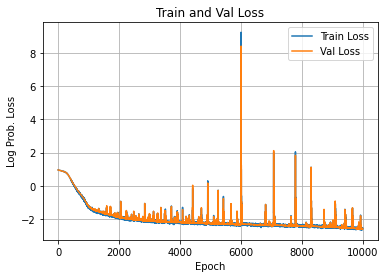

In [49]:
ovs_data_gen = DataGenerator('./net_model_dataset/ovs/input_dataset.pkl', './net_model_dataset/ovs/output_dataset.pkl', vnf_type='OvS', norm_type='minmax')
ovs_model = VNF_Model(vnf_typ='ovs', 
                      n_inputs=6,
                      n_hidden=[64, 32, 16],
                      n_outputs=5) # <--- Create the VNF model
ovs_model.to(device)

# OVS model Plots
train_loss, val_loss = ovs_model.train(ovs_data_gen, num_epochs=10000, batch_size=512) # <--- Train the VNF model
ovs_model.plot_loss()

Test Loss: -5.520680427551269531633758545, Val Loss: -5.1656484603881848534665


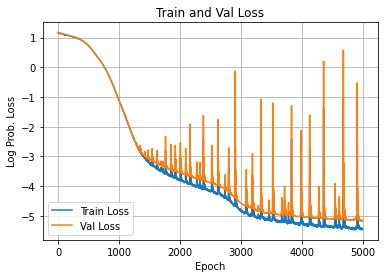

In [50]:
upf_data_gen = DataGenerator('./net_model_dataset/upf/input_dataset.pkl', './net_model_dataset/upf/output_dataset.pkl', vnf_type='UPF', norm_type='minmax')
upf_model = VNF_Model(vnf_typ='upf', 
                      n_inputs=6,
                      n_hidden=[32, 16],
                      n_outputs=5) # <--- Create the VNF model
upf_model.to(device)

# UPF model Plots
train_loss, val_loss = upf_model.train(upf_data_gen, num_epochs=5000, batch_size=512) # <--- Train the VNF model
upf_model.plot_loss()

<div style="font-family: 'Courier New', Courier, monospace; font-size: 1.8em; color: #f6f8fa; background-color: #24292e; border: 2px solid #444d56; border-radius: 6px; padding: 10px 20px; margin-top: 20px; box-shadow: 0 2px 5px rgba(0, 0, 0, 0.1);">
    <span style="font-weight: 600; font-size: 1.1em; letter-spacing: 0.5px; color: #f0f6fc;">5. Slice Modeling</span>
</div>


<div style="font-family: 'Arial', sans-serif; line-height: 1.7; color: #333; max-width: 800px; margin: auto; padding: 15px;">

  <p style="font-size: 1.2em; margin-bottom: 20px;">
    In this part of the notebook, we will conncet the VNF models to compose an end-to-end slice model.  Before we begin, let's take a look at the `SliceModel` class in <a href="https://github.com/sulaimanalmani/5GDynamicResourceAllocation/blob/main/slice_model.py" target="_blank" style="color: #2196F3; text-decoration: none;">slice_model.py</a>.
  </p>
</div>

<div style="font-family: 'Arial', sans-serif; line-height: 1.7; color: #333; max-width: 1000px; margin: auto; padding: 15px;">
  <div align="center" style="margin: 25px 0; padding: 15px; background-color: white; border: 1px solid #444; border-radius: 8px;">
    <img src="images/vNetRunner.png" alt="vNetRunner Overview" width="600"" />
  </div>
</div>

<div style="display: inline-block;">
    <h2 style="font-family: 'Courier New', Courier, monospace; font-size: 1.5em; color: #f0f6fc; background-color: #2d333b; border-left: 4px solid #3F51B5; padding: 8px 15px; border-radius: 4px; margin-top: 20px; box-shadow: 0 1px 3px rgba(0, 0, 0, 0.1">
        5a. Loading pre-trained VNF models
    </h2>
</div>

In [113]:
# upf_data_gen = DataGenerator('./net_model_dataset/upf/input_dataset.pkl', './net_model_dataset/upf/output_dataset.pkl', vnf_type='UPF', norm_type='minmax')
# ovs_data_gen = DataGenerator('./net_model_dataset/ovs/input_dataset.pkl', './net_model_dataset/ovs/output_dataset.pkl', vnf_type='OvS', norm_type='minmax')
# ran_data_gen = DataGenerator('./net_model_dataset/ran/input_dataset.pkl', './net_model_dataset/ran/output_dataset.pkl', vnf_type='RAN', norm_type='minmax')

# ovs_model = VNF_Model('ovs', 6, [64, 32, 16], 5)
# ovs_model.to(device)
# ovs_model.load_weights('./data/saved_weights/ovs/model.pth')

# upf_model = VNF_Model('upf', 6, [32, 16], 5)
# upf_model.to(device)
# upf_model.load_weights('./data/saved_weights/upf/model.pth')

# ran_model = VNF_Model('ran', 6, [64, 32, 16], 5)
# ran_model.to(device)
# ran_model.load_weights('./data/saved_weights/ran/model.pth')

<div style="display: inline-block;">
    <h2 style="font-family: 'Courier New', Courier, monospace; font-size: 1.5em; color: #f0f6fc; background-color: #2d333b; border-left: 4px solid #3F51B5; padding: 8px 15px; border-radius: 4px; margin-top: 20px; box-shadow: 0 1px 3px rgba(0, 0, 0, 0.1">
        5b. Creating the Slice Model
    </h2>
</div>

In [51]:
from slice_model import SliceModel
data_gens = [upf_data_gen, ovs_data_gen, ran_data_gen]
vnf_models = [upf_model, ovs_model, ran_model]
slice_model = SliceModel(vnf_models, data_gens)


In [61]:
resource_allocation = {'UPF': 200, #CPU (millicores)
                       'OVS': 50, #Throughput (Mbps)
                       'RAN': 1000} #CPU (millicores)
input_throughput = 35

output_throughput = slice_model.predict_throughput(res = list(resource_allocation.values()),
                                                    input_throughput= input_throughput,
                                                    differentiable=0,
                                                    res_normalized=False)
print(output_throughput)

22.344955444335938


<div style="display: inline-block;">
    <h2 style="font-family: 'Courier New', Courier, monospace; font-size: 1.5em; color: #f0f6fc; background-color: #2d333b; border-left: 4px solid #3F51B5; padding: 8px 15px; border-radius: 4px; margin-top: 20px; box-shadow: 0 1px 3px rgba(0, 0, 0, 0.1">
        5c. Interacting with the Slice Model
    </h2>
</div>

In [62]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Define sliders for resource allocations and input throughput
upf_slider = widgets.IntSlider(
    value=200+(500-200)/2, min=200, max=500, step=5,
    description='UPF CPU (millicores):',
    continuous_update=True,
    style={'description_width': '200px'},
    layout=widgets.Layout(width='50%', padding='10px 0px'))

ovs_slider = widgets.IntSlider(
    value=10+(50-10)/2, min=10, max=50, step=1,
    description='OVS Throughput (Mbps):',
    continuous_update=True,
    style={'description_width': '200px'},
    layout=widgets.Layout(width='50%', padding='10px 0px')
)

ran_slider = widgets.IntSlider(
    value=250+(2000-250)/2, min=250, max=2000, step=10,
    description='RAN CPU (millicores):',
    continuous_update=True,
    style={'description_width': '200px'},
    layout=widgets.Layout(width='50%', padding='10px 0px')
)

input_throughput_slider = widgets.IntSlider(
    value=5+(50-5)/2, min=5, max=50, step=0.1,
    description='Input Throughput (Mbps):',
    continuous_update=True,
    style={'description_width': '200px'},
    layout=widgets.Layout(width='50%', padding='10px 0px'))

# Create output label for output throughput
output_throughput_label = widgets.Label("Output Throughput (Mbps):", layout=widgets.Layout(width='200px', padding="5px", font_weight='bold'))
output_throughput_value = widgets.Label("", layout=widgets.Layout(width='150px', padding="5px"))

# Plot output widget
plot_output = widgets.Output()

# Plot update function
def update_plot(output_throughput):
    with plot_output:
        plot_output.clear_output(wait=True)
        plt.figure(figsize=(5, 2))
        plt.bar(["Output Throughput"], [output_throughput], color='skyblue')
        plt.ylim(0, 100)  # Adjust based on expected range
        plt.ylabel("Throughput (Mbps)")
        plt.title("Output Throughput Visualization")
        plt.show()

# Update function for output throughput
def update_output(change=None):
    # Get values from sliders
    resource_allocation = {
        'UPF': upf_slider.value,
        'OVS': ovs_slider.value,
        'RAN': ran_slider.value
    }
    input_throughput = input_throughput_slider.value
    
    # Predict output throughput
    output_throughput = slice_model.predict_throughput(res = list(resource_allocation.values()),
                                                        input_throughput= input_throughput,
                                                        res_normalized=False)
    output_throughput_value.value = f"{output_throughput:.1f} Mbps"
    
    # Update the plot with the new output throughput
    update_plot(output_throughput)

# Bind slider updates to the function and display all widgets
upf_slider.observe(update_output, names='value')
ovs_slider.observe(update_output, names='value')
ran_slider.observe(update_output, names='value')
input_throughput_slider.observe(update_output, names='value')

# Display the widgets
display(upf_slider, ovs_slider, ran_slider, input_throughput_slider, 
        widgets.HBox([output_throughput_label, output_throughput_value]), plot_output)

# Initialize with default slider values
update_output()

IntSlider(value=350, description='UPF CPU (millicores):', layout=Layout(padding='10px 0px', width='50%'), max=…

IntSlider(value=30, description='OVS Throughput (Mbps):', layout=Layout(padding='10px 0px', width='50%'), max=…

IntSlider(value=1125, description='RAN CPU (millicores):', layout=Layout(padding='10px 0px', width='50%'), max…

IntSlider(value=27, description='Input Throughput (Mbps):', layout=Layout(padding='10px 0px', width='50%'), ma…

Output()

<div style="display: inline-block;">
    <h2 style="font-family: 'Courier New', Courier, monospace; font-size: 1.5em; color: #f0f6fc; background-color: #2d333b; border-left: 4px solid #3F51B5; padding: 8px 15px; border-radius: 4px; margin-top: 20px; box-shadow: 0 1px 3px rgba(0, 0, 0, 0.1">
        5d. Validating the Slice Model
    </h2>
</div>

In [ ]:
slice_data_gen = DataGenerator("./net_model_dataset/slice/input_dataset.pkl", "./net_model_dataset/slice/output_dataset.pkl", vnf_type='slice')
pred = slice_model.predict_slice_data_gen(slice_data_gen)
pred = pred.detach().cpu().numpy()
pred_throughput = pred[:, 2]
train_output = slice_data_gen.output_dataset.iloc[:, 2]

# Plot throughput reg line (actual vs predicted)
plt.clf()
plt.scatter(train_output, pred_throughput, label='Composite', alpha=0.5)
plt.xlabel('Actual Throughput (Mbps)')
plt.ylabel('Predicted Throughput (Mbps)')
plt.grid()
plt.plot([0, 35], [0, 35], color='black', alpha=0.5)
plt.legend()
plt.show()